In [1]:
#plan
#calculate mean points for each tof bin
#calculate the mean distance from the midpoints to the reconstruction
#plot

In [2]:

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets.widgets import * 
import ipywidgets as widgets

#Hugo code
import kex_headers
import kex_data
import petlink
import representation
import position
import listmode

In [3]:
listmode_data, listmode_paths = kex_data.listmode()

In [4]:
events = []
count = 1000*1000
for lm in listmode_data:
    events.append(petlink.get_events(lm[:count]))

In [5]:
tof_mean_lor = []

for ev in events:
    tof_lor = petlink.get_tof_lor_bins(ev, kex_headers.HISTOGRAM_SHAPE)
    means = []
    for t in range(13):
        #direct LOR in tofbin
        m = np.mean(tof_lor[:, np.all([tof_lor[0]==t, 
                                                tof_lor[1] < kex_headers.SEGMENT_TABLE[0]],axis=0)], 
                             axis=1)
        means.append(m)
    
    tof_mean_lor.append(means)
tof_mean_lor = np.array(tof_mean_lor)
tof_mean_lor = np.swapaxes(tof_mean_lor, 1,2)

In [6]:
mean_img_bins = []
mean_midpoint_bins = []
mean_R_axis_bins = []
for mean_lor in tof_mean_lor:
    temp = np.array(mean_lor, dtype=int)
    mean_img_bins.append(representation.get_image_bins(temp, timealign=True))
    temp[0]=0
    mean_midpoint_bins.append(representation.get_image_bins(temp, timealign=True))
    temp[-1] = 250
    mean_R_axis_bins.append(representation.get_image_bins(temp, timealign=False))

In [7]:
recons, _ = kex_data.reconstructions()
recon_com = []
for r in recons:
    recon_com.append(position.center_of_mass(r))

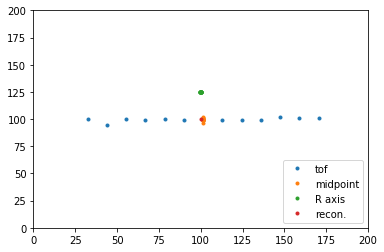

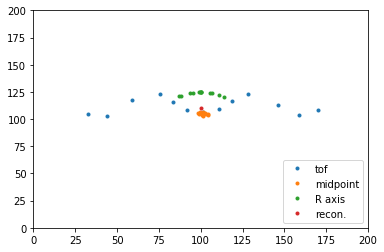

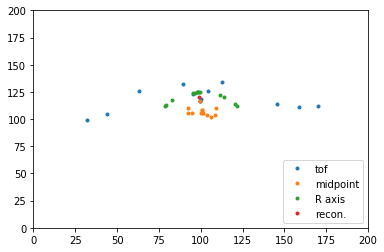

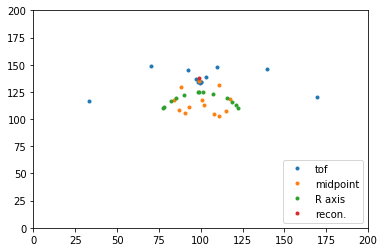

In [8]:
for k, mean in enumerate(mean_img_bins):
    plt.xlim(0,200)
    plt.ylim(0,200)
    data = [mean, mean_midpoint_bins[k], mean_R_axis_bins[k], recon_com[k]]
    for d in data:
        y,x = d[1:]
        plt.plot(x,y, '.')
    plt.legend(["tof", "midpoint", "R axis", "recon."], loc='lower right')
    plt.show()

In [9]:
h_images = []
for img_bins in mean_img_bins:
    shape = kex_headers.IMAGE_SHAPE
    img_bins = img_bins[:, listmode.is_fov(img_bins, shape)]
    h_images.append(listmode.get_histogram(img_bins, shape))

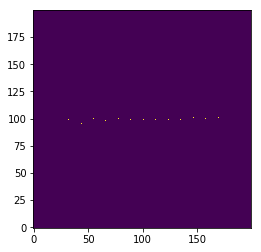

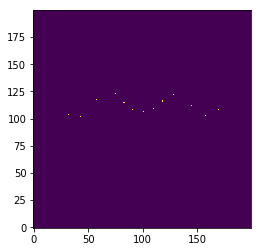

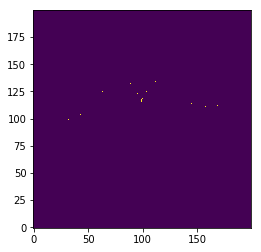

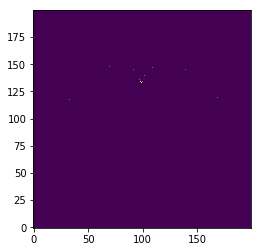

In [10]:
for h in h_images: 
    plt.imshow(np.sum(h,axis=0), origin='down')
    plt.show()

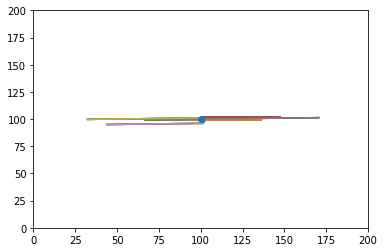

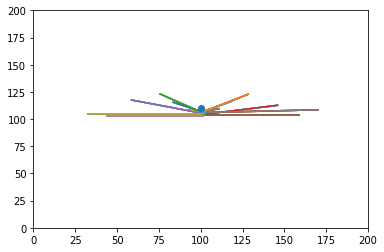

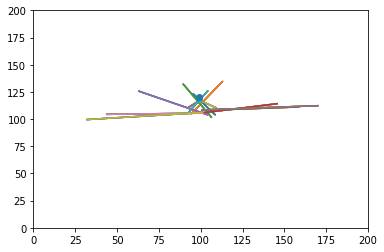

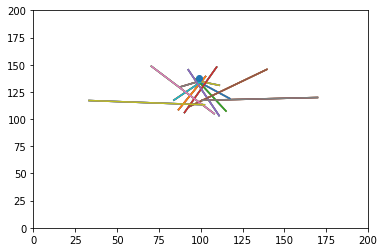

In [11]:
#from_to = np.append(mean_midpoint_bins, mean_img_bins, axis=2)
#print(from_to.shape)

for k in range(4):
    plt.xlim(0,200)
    plt.ylim(0,200)
    for t in range(5):
        ya,xa = mean_midpoint_bins[k][1:]
        yb,xb = mean_img_bins[k][1:]
        plt.plot([xa,xb],[ya,yb])
        plt.plot(xa[0], ya[0],'.')
    y,x = recon_com[k][1:]
    plt.plot(x,y, 'o')
    plt.show()

In [12]:
distances = []
for k, midpoints in enumerate(mean_midpoint_bins):
    #scale back to mm
    ref_mm = recon_com[k]*kex_headers.MM_PER_PIXEL
    ref_midpoints = midpoints * np.expand_dims(kex_headers.MM_PER_PIXEL, axis=1)
    diff = ref_mm - np.swapaxes(ref_midpoints, 0,1)
    #print(diff.shape)
    norms = np.linalg.norm(diff, axis=1)
    #print(norms.shape)
    distances.append(norms)
distances = np.array(distances)
#print(distances.shape)

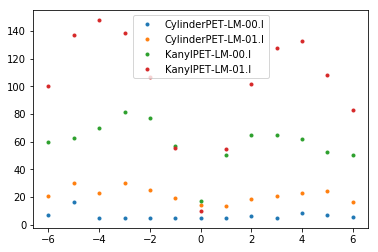

In [13]:
legends = []
for k,d in enumerate(distances):
    plt.plot(kex_headers.TOF_OFFSET_MAP, d, '.')
    legends.append(listmode_paths[k].split("/")[-1])
plt.legend(legends)

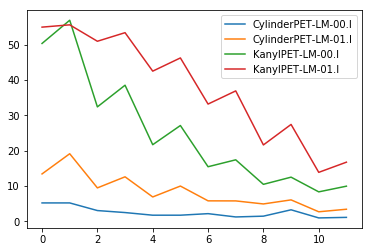

In [14]:
for k,d in enumerate(distances):
    plt.plot(d[1:] / np.abs(kex_headers.TOF_OFFSET_MAP[1:]))
plt.legend(legends)

In [15]:
print(mean_midpoint_bins[0].shape)

(3, 13)


In [16]:
sinograms, sino_paths = kex_data.sinograms()

In [17]:
argmax_flat = []
for sino in sinograms:
    temp = []
    for t in range(13):
        temp.append(np.argmax(sino[t]))
    argmax_flat.append(temp)

In [18]:
print(temp)

[16701876, 40630272, 3253874, 16848659, 10302261, 16926628, 27027843, 17000207, 22915801, 21904611, 10349802, 21904611, 10417002]


In [19]:
argmax_lor = []
shape = kex_headers.LOR_HISTOGRAM_SHAPE
for flats in argmax_flat:

    lor_bins = np.unravel_index(flats, shape)
    argmax_lor.append(np.array(lor_bins)  ) 

In [20]:
print(argmax_lor[0][:,0])

[ 41  69 241]


In [21]:
def histo(lor, tof):
    tof = np.expand_dims(tof, axis=0)
    toflor = np.append(tof, lor, axis=0)
    pixels = representation.get_image_bins(toflor)
    img_shape = kex_headers.IMAGE_SHAPE
    fov_pix = pixels[:, listmode.is_fov(pixels, img_shape)]
    return listmode.get_histogram(fov_pix, img_shape)

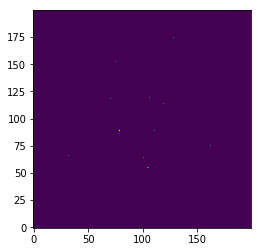

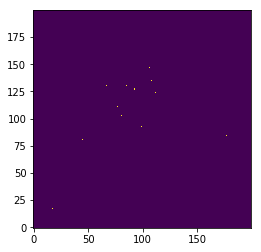

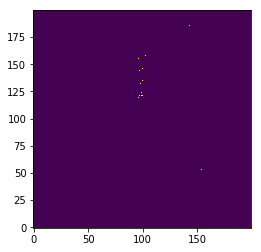

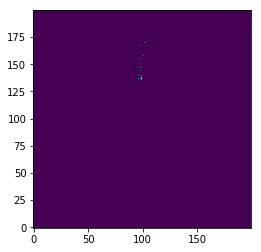

In [22]:
h_tof = []
tofbins = np.arange(13)
for lor in argmax_lor:
    h = histo(lor, tofbins)
    h_tof.append(h)
    plt.imshow(np.sum(h, axis=0), origin='down')
    plt.show()
    

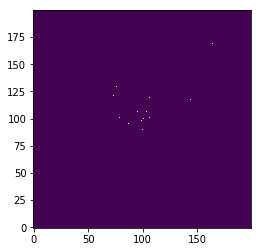

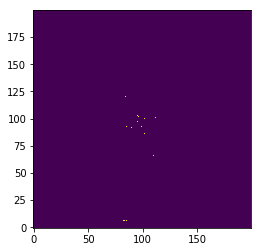

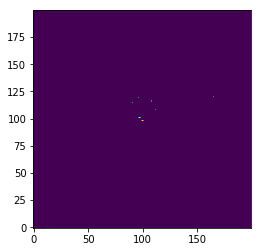

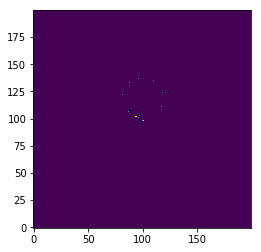

In [23]:
h_mid = []
tofbins = np.zeros(13, dtype=int)
for lor in argmax_lor:
    h = histo(lor, tofbins)
    h_mid.append(h)
    plt.imshow(np.sum(h, axis=0), origin='down')
    plt.show()